# Check whether the bias in axisymmetric vs spherical JAM is independent of mass normalization and shape of stellar tracer

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

from copy import deepcopy

In [2]:
from deproject.Profiles.SIS_truncated_physical import SIS_truncated_physical
from deproject.Profiles.Hernquist import Hernquist
from deproject.Cosmo.default_cosmo import get_default_lens_cosmo
from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_half_light_isophote import mge_half_light_isophote
from deproject.MGE_analysis.mge_proj import MGE_Proj
from deproject.MGE_analysis.intr_mge import Intr_MGE

from plotbin.plot_velfield import plot_velfield
from deproject.MGE_analysis.mge_misc import sum_gaussian_components

## "Bias" is mass normalization independent?

In [3]:
qintr_test = 0.5
sigma_rm = np.linspace(200, 400, 10)
inc_test = np.radians(40)


m_star = 1e11
rs_kpc = 8

In [4]:
def get_truncsis_intr_mge(sigma_v, rc_kpc, r_sym, qintr, plot_mge=0, fignum=1):
    """get the amplitude and dispersion of the MGE describing the INTRINSIC mass density/stellar light profile along the symmetry axis 

    Args:
        sigma_v (_type_): sigma_sph of the truncated SIS profile
        rc_kpc (_type_): truncation radius in kpc
        r_sym (_type_): coordinate along the symmetry axis
        qintr (_type_): intrinsic axis ratio. If oblate, qintr < 1; if prolate, qintr > 1
        plot_mge (int, optional): _description_. Defaults to 0.
        fignum (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: amplitude in M_sun/pc^3
        _type_: dispersion in pc
    """
    sis_profile = SIS_truncated_physical(sigma_v=sigma_v, rc = rc_kpc)
    intr_mge = Intr_MGE(profile=sis_profile, qintr=qintr, r_sym=r_sym)
    peak, sigma = intr_mge.MGE_param(kwargs_mge={'ngauss': 20, 'inner_slope': 3, 'outer_slope':1}, plot_mge=plot_mge, fignum=fignum)

    peak = peak / 1e9 # convert to [M_sun/pc^3]
    sigma = sigma * 1e3 # convert to [pc]

    return peak, sigma

def get_hernquist_intr_mge(m_star, Rs_kpc, qintr, plot_mge=0, fignum=1):

    hernquist_profile = Hernquist(Rs=Rs_kpc, sigma0=1e7)

    r_sym = np.geomspace(0.001, 10 * Rs_kpc, 300)

    intr_mge = Intr_MGE(profile=hernquist_profile, qintr=qintr, r_sym=r_sym)

    peak, sigma = intr_mge.MGE_param(kwargs_mge = {'ngauss': 20}, plot_mge=plot_mge, fignum=fignum)

    peak = peak / 1e9 # convert to [M_sun/pc^3]
    sigma = sigma * 1e3 # convert to [pc]

    mtot = intr_mge.MGE_mass_sph()
    peak = m_star / mtot * peak # rescale to desired input stellar mass

    return peak, sigma


def get_proj_mge(mge_proj, distance, inc):
    """get projected MGE

    Args:
        mge_proj (_type_): MGE_proj instance
        distance (_type_): angular diameter distance in Mpc, used to convert the dispersion to arcsec
        inc (_type_): inclination angle [rad]

    Returns:
        _type_: peak of the projected MGE [M_sun/pc^3]
        _type_: sigma of the projected MGE [arcsec]
        _type_: projected axis ratio 
    """
    surf = mge_proj.surf(inc=inc)
    qobs = mge_proj.qobs(inc=inc)

    qobs = np.full_like(surf, qobs)

    pc = distance * np.pi / 0.648
    sigma_intr = mge_proj.sigma
    sigma = sigma_intr / pc

    return surf, sigma, qobs

def get_sigma_e(surf_lum, sigma_lum, qobs_lum, jam, xbin, ybin, plot=0, fignum=1):
    """calculate velocity dispersion within half light radius; if prolate model (qobs > 1), isophote will have a 90 degrees misalignment with kinematics field

    Args:
        surf_lum (_type_): _description_
        sigma_lum (_type_): _description_
        qobs_lum (_type_): _description_
        jam (_type_): _description_
        xbin (_type_): _description_
        ybin (_type_): _description_
        plot (int, optional): _description_. Defaults to 0.
        fignum (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: velocity dispersion [km/s]
    """
    reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(surf_lum, sigma_lum, qobs_lum)
    w = xbin**2 + (ybin/(1 - eps_e))**2 < reff_maj**2
    flux = jam.flux
    model = jam.model
    sig_e = np.sqrt((flux[w]*model[w]**2).sum()/flux[w].sum())

    if plot:
        plt.figure(fignum)
        plot_velfield(xbin, ybin, model, flux=flux, nodots=1, colorbar=1)
        ax = plt.gca()
        ax.plot(xbin[w], ybin[w], ',')
        ax.set_xlabel('arcsec')
        ax.set_ylabel('arcsec')
        print('R_eff = {:.2f} arcsec' .format(reff))

    print('sigma_e = {:.2f} km/s' .format(sig_e))

    return sig_e

def sphericalize_2d(sigma_proj, qobs):
    return sigma_proj * np.sqrt(qobs)

def total_mass_3d(peak, sigma, qintr):
    """total MGE mass calculated from intrinsic MGE

    Args:
        peak (_type_): _description_
        sigma (_type_): _description_
        qintr (_type_): _description_

    Returns:
        _type_: _description_
    """
    return np.sum(peak * (sigma * np.sqrt(2 * np.pi))**3 * qintr)

def total_mass_2d(peak, sigma, qobs):
    """total MGE mass calculated from projected MGE

    Args:
        peak (_type_): _description_
        sigma (_type_): _description_
        qobs (_type_): _description_

    Returns:
        _type_: _description_
    """
    return np.sum(2 * np.pi * peak * qobs * sigma**2)


In [5]:
# sigma_v = sigma_rm[3]

ratio = []

if 1:

    for sigma_v in sigma_rm:

        # define density profile
        lens_cosmo = get_default_lens_cosmo()
        distance = lens_cosmo.Dd
        theta_sis = lens_cosmo.sis_sigma_v2theta_E(sigma_v)
        rc_kpc = lens_cosmo.arcsec2Mpc_lens(theta_sis) * 1e3 * 200
        r_sym = np.geomspace(0.01, 5 * rc_kpc, 300)

        # intrinsic MGE for 3d spherical models and 3d axisymmetric models
        peak_sph3d, sigma_sph3d = get_truncsis_intr_mge(sigma_v, rc_kpc, r_sym, 1.0)
        peak_axi3d, sigma_axi3d = get_truncsis_intr_mge(sigma_v, rc_kpc, r_sym, qintr_test)

        # verify total mass
        # print(total_mass_3d(peak_sph3d, sigma_sph3d, 1) / 1e13)
        # print(total_mass_3d(peak_axi3d, sigma_axi3d, qintr_test) / 1e13)

        # calculate projected MGE
        mge_proj_axi = MGE_Proj(peak_axi3d, sigma_axi3d, qintr_test)
        mge_proj_sph = MGE_Proj(peak_sph3d, sigma_sph3d, 1.0)
        peak_axi3d_proj, sigma_axi3d_proj, qobs_axi_proj = get_proj_mge(mge_proj_axi, distance, inc_test) # project axisymmetric MGE
        peak_sph3d_proj, sigma_sph3d_proj, qobs_sph_proj = get_proj_mge(mge_proj_sph, distance, inc_test) # project intrinsically spherical MGE

        # circularize projected axisymmetric MGE 
        sigma_axi3d_proj_sph = sphericalize_2d(sigma_axi3d_proj, qobs_axi_proj)
        qobs_axi3d_proj_sph = np.ones_like(sigma_axi3d_proj_sph)

        # verify total mass
        pc = distance * np.pi / 0.648
        # print(total_mass_2d(peak_axi3d_proj, sigma_axi3d_proj, qobs_axi_proj) * pc**2 / 1e13)
        # print(total_mass_2d(peak_sph3d_proj, sigma_sph3d_proj, qobs_sph_proj) * pc**2 / 1e13)
        # print(total_mass_2d(peak_axi3d_proj, sigma_axi3d_proj_sph, qobs_axi3d_proj_sph) * pc**2 / 1e13)

        # get intrinsic MGE for light
        peak_sph3d_lum, sigma_sph3d_lum = get_hernquist_intr_mge(m_star, rs_kpc, 1.0)
        peak_axi3d_lum, sigma_axi3d_lum = get_hernquist_intr_mge(m_star, rs_kpc, qintr_test)

        # project intrinsic MGE for projected MGE
        mge_proj_sph_lum = MGE_Proj(peak_sph3d_lum, sigma_sph3d_lum, 1.0)
        mge_proj_axi_lum = MGE_Proj(peak_axi3d_lum, sigma_axi3d_lum, qintr_test)
        peak_axi3d_proj_lum, sigma_axi3d_proj_lum, qobs_axi_proj_lum = get_proj_mge(mge_proj_axi_lum, distance, inc_test) # project axisymmetric MGE
        peak_sph3d_proj_lum, sigma_sph3d_proj_lum, qobs_sph_proj_lum = get_proj_mge(mge_proj_sph_lum, distance, inc_test)# project intrinsically spherical MGE

        # circularize projected axisymmetric MGE 
        sigma_axi3d_proj_lum_sph = sphericalize_2d(sigma_axi3d_proj_lum, qobs_axi_proj_lum)
        qobs_axi3d_proj_lum_sph = np.ones_like(sigma_axi3d_proj_lum_sph)

        xx = np.linspace(-4 * theta_sis, 4 * theta_sis, 100)  # avoid (x,y)=(0,0)
        xbin, ybin = map(np.ravel, np.meshgrid(xx, xx))

        # run axisymmetric JAM modeling
        beta_axi3d = np.zeros_like(peak_axi3d_proj)

        jam_axi3d = jam_axi_proj(peak_axi3d_proj_lum, sigma_axi3d_proj_lum, qobs_axi_proj_lum, peak_axi3d_proj, sigma_axi3d_proj, qobs_axi_proj, np.degrees(inc_test), 0, distance, xbin, ybin, align='sph', beta = beta_axi3d)

        # plt.figure(2)
        sigma_e_axi3d = get_sigma_e(peak_axi3d_proj_lum, sigma_axi3d_proj_lum, qobs_axi_proj_lum, jam_axi3d, xbin, ybin, plot = False, fignum = 2)
        # ax = plt.gca()
        # ax.set_xlabel('arcsec', size = 20)
        # ax.set_ylabel('arcsec', size = 20)
        # ax.figure.axes[1].set_ylabel(r'$\sigma$ [km/s]', size = 20)

        # plt.show()

        # run circularized axisymmetric JAM modeling
        jam_axi3d_proj = jam_axi_proj(peak_axi3d_proj_lum, sigma_axi3d_proj_lum_sph, qobs_axi3d_proj_lum_sph, peak_axi3d_proj, sigma_axi3d_proj_sph, qobs_axi3d_proj_sph, np.degrees(inc_test), 0, distance, xbin, ybin, align = 'sph', beta = beta_axi3d)

        # plt.figure(3)
        sigma_e_axi3d_sph = get_sigma_e(peak_axi3d_proj_lum, sigma_axi3d_proj_lum_sph, qobs_axi3d_proj_lum_sph, jam_axi3d_proj, xbin, ybin, plot = False, fignum=3)

        # plt.show()

        # print(sigma_e_axi3d/sigma_e_axi3d_sph)
        ratio.append(sigma_e_axi3d/sigma_e_axi3d_sph)

jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 1.18
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.124e+13

sigma_e = 160.69 km/s
jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.65
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.124e+13

sigma_e = 167.19 km/s
jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.73
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.236e+13

sigma_e = 178.51 km/s
jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.64
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolu

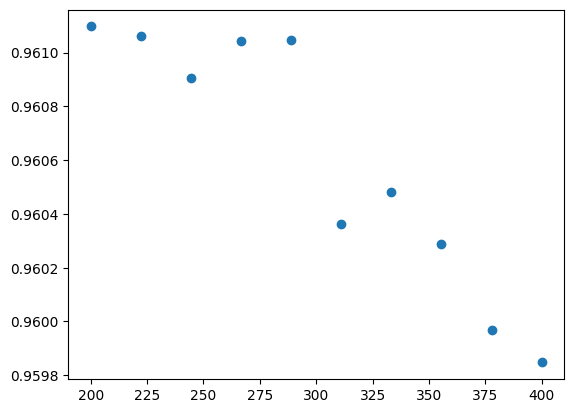

In [6]:
plt.scatter(sigma_rm, ratio)
# plt.ylim(0.92, .98)

In [7]:
# # get intrinsic MGE for light
# peak_sph3d_lum, sigma_sph3d_lum = get_hernquist_intr_mge(m_star, rs_kpc, 1.0)
# peak_axi3d_lum, sigma_axi3d_lum = get_hernquist_intr_mge(m_star, rs_kpc, qintr_test)

# # project intrinsic MGE for projected MGE
# mge_proj_sph_lum = MGE_Proj(peak_sph3d_lum, sigma_sph3d_lum, 1.0)
# mge_proj_axi_lum = MGE_Proj(peak_axi3d_lum, sigma_axi3d_lum, qintr_test)
# peak_axi3d_proj_lum, sigma_axi3d_proj_lum, qobs_axi_proj_lum = get_proj_mge(mge_proj_axi_lum, distance, inc_test) # project axisymmetric MGE
# peak_sph3d_proj_lum, sigma_sph3d_proj_lum, qobs_sph_proj_lum = get_proj_mge(mge_proj_sph_lum, distance, inc_test)# project intrinsically spherical MGE

# # circularize projected axisymmetric MGE 
# sigma_axi3d_proj_lum_sph = sphericalize_2d(sigma_axi3d_proj_lum, qobs_axi_proj_lum)
# qobs_axi3d_proj_lum_sph = np.ones_like(sigma_axi3d_proj_lum_sph)

# xx = np.linspace(-4 * theta_sis, 4 * theta_sis, 100)  # avoid (x,y)=(0,0)
# xbin, ybin = map(np.ravel, np.meshgrid(xx, xx))

In [8]:
# # run axisymmetric JAM modeling
# beta_axi3d = np.zeros_like(peak_axi3d_proj)

# jam_axi3d = jam_axi_proj(peak_axi3d_proj_lum, sigma_axi3d_proj_lum, qobs_axi_proj_lum, peak_axi3d_proj, sigma_axi3d_proj, qobs_axi_proj, np.degrees(inc_test), 0, distance, xbin, ybin, align='sph', beta = beta_axi3d)

# plt.figure(2)
# sigma_e_axi3d = get_sigma_e(peak_axi3d_proj_lum, sigma_axi3d_proj_lum, qobs_axi_proj_lum, jam_axi3d, xbin, ybin, plot = True, fignum = 2)
# ax = plt.gca()
# ax.set_xlabel('arcsec', size = 20)
# ax.set_ylabel('arcsec', size = 20)
# ax.figure.axes[1].set_ylabel(r'$\sigma$ [km/s]', size = 20)

# plt.show()

# # run circularized axisymmetric JAM modeling
# jam_axi3d_proj = jam_axi_proj(peak_axi3d_proj_lum, sigma_axi3d_proj_lum_sph, qobs_axi3d_proj_lum_sph, peak_axi3d_proj, sigma_axi3d_proj_sph, qobs_axi3d_proj_sph, np.degrees(inc_test), 0, distance, xbin, ybin, align = 'sph', beta = beta_axi3d)

# plt.figure(3)
# sigma_e_axi3d_sph = get_sigma_e(peak_axi3d_proj_lum, sigma_axi3d_proj_lum_sph, qobs_axi3d_proj_lum_sph, jam_axi3d_proj, xbin, ybin, plot = True, fignum=3)

# plt.show()

# print(sigma_e_axi3d/sigma_e_axi3d_sph)

## "Bias" is stellar profile independent? 

### the Jaffe profile

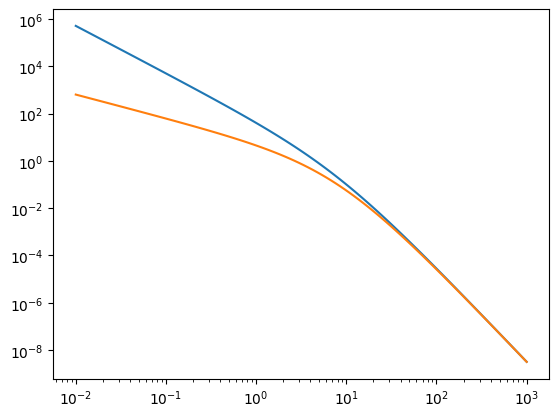

In [9]:
def jaffe(r, rho0, r0):
    return rho0 / 4 / np.pi * (r/r0)**(-2) * (1 + r/r0)**(-2)

def hernquist(r, rho0, r0):
    return rho0 / 4 / np.pi * (r/r0)**(-1) * (1 + r/r0)**(-3)

rho0 = 10.
r0 = 8
r = np.geomspace(0.01, 1000, 100)

plt.loglog(r, jaffe(r, rho0, r0))
plt.loglog(r, hernquist(r, rho0, r0))

In [10]:
from deproject.Profiles.Hernquist import Hernquist
from deproject.Profiles.Jaffe import Jaffe

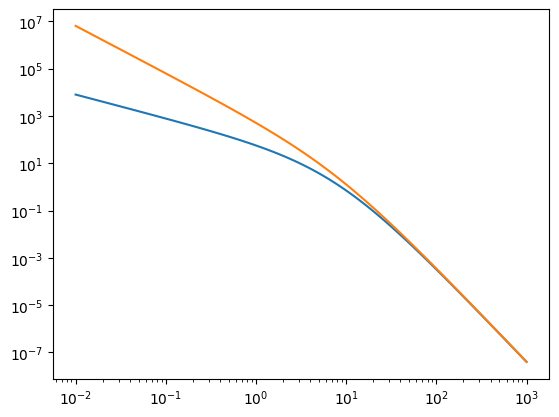

In [11]:
sigma0 = Hernquist.rho2sigma0(rho0, r0)
hernquist_profile = Hernquist(r0, sigma0)
jaffe_profile = Jaffe(r0, rho0)

plt.loglog(r, hernquist_profile.Density_3d_spherical(r))
plt.loglog(r, jaffe_profile.Density_3d_spherical(r))

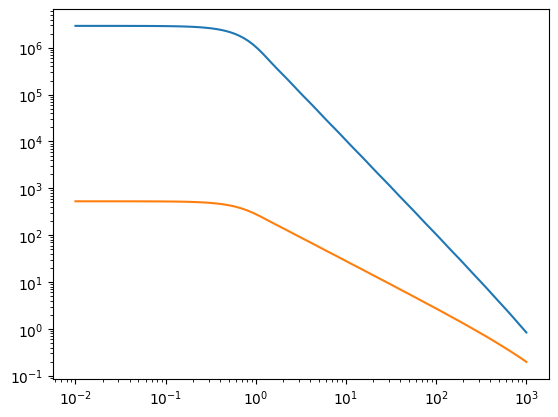

In [12]:
# mge decomposition of the Jaffe profile

def get_jaffe_intr_mge(m_star, rs_kpc, qintr, plot_mge=0, fignum=1):

    jaffe_profile = Jaffe(rs=rs_kpc, rho0=1e5)

    r_sym = np.geomspace(0.001, 10 * rs_kpc, 300)

    intr_mge = Intr_MGE(profile=jaffe_profile, qintr=qintr, r_sym=r_sym)

    peak, sigma = intr_mge.MGE_param(kwargs_mge = {'ngauss': 20}, plot_mge=plot_mge, fignum=fignum)

    peak = peak / 1e9 # convert to [M_sun/pc^3]
    sigma = sigma * 1e3 # convert to [pc]

    mtot = intr_mge.MGE_mass_sph()
    peak = m_star / mtot * peak # rescale to desired input stellar mass
    return peak, sigma


peak_jaffe, sigma_jaffe = get_jaffe_intr_mge(1e11, 8, 1, plot_mge=0, fignum=1)
peak_hernquist, sigma_hernquist = get_hernquist_intr_mge(1e11, 8, 1, plot_mge=0, fignum=2)

plt.loglog(r, sum_gaussian_components(r, peak_jaffe, sigma_jaffe))
plt.loglog(r, sum_gaussian_components(r, peak_hernquist, sigma_hernquist))

In [13]:
ratio = []

if 1:

    for sigma_v in sigma_rm:

        # define density profile
        lens_cosmo = get_default_lens_cosmo()
        distance = lens_cosmo.Dd
        theta_sis = lens_cosmo.sis_sigma_v2theta_E(sigma_v)
        rc_kpc = lens_cosmo.arcsec2Mpc_lens(theta_sis) * 1e3 * 200
        r_sym = np.geomspace(0.01, 5 * rc_kpc, 300)

        # intrinsic MGE for 3d spherical models and 3d axisymmetric models
        peak_sph3d, sigma_sph3d = get_truncsis_intr_mge(sigma_v, rc_kpc, r_sym, 1.0)
        peak_axi3d, sigma_axi3d = get_truncsis_intr_mge(sigma_v, rc_kpc, r_sym, qintr_test)

        # verify total mass
        # print(total_mass_3d(peak_sph3d, sigma_sph3d, 1) / 1e13)
        # print(total_mass_3d(peak_axi3d, sigma_axi3d, qintr_test) / 1e13)

        # calculate projected MGE
        mge_proj_axi = MGE_Proj(peak_axi3d, sigma_axi3d, qintr_test)
        mge_proj_sph = MGE_Proj(peak_sph3d, sigma_sph3d, 1.0)
        peak_axi3d_proj, sigma_axi3d_proj, qobs_axi_proj = get_proj_mge(mge_proj_axi, distance, inc_test) # project axisymmetric MGE
        peak_sph3d_proj, sigma_sph3d_proj, qobs_sph_proj = get_proj_mge(mge_proj_sph, distance, inc_test) # project intrinsically spherical MGE

        # circularize projected axisymmetric MGE 
        sigma_axi3d_proj_sph = sphericalize_2d(sigma_axi3d_proj, qobs_axi_proj)
        qobs_axi3d_proj_sph = np.ones_like(sigma_axi3d_proj_sph)

        # verify total mass
        pc = distance * np.pi / 0.648
        # print(total_mass_2d(peak_axi3d_proj, sigma_axi3d_proj, qobs_axi_proj) * pc**2 / 1e13)
        # print(total_mass_2d(peak_sph3d_proj, sigma_sph3d_proj, qobs_sph_proj) * pc**2 / 1e13)
        # print(total_mass_2d(peak_axi3d_proj, sigma_axi3d_proj_sph, qobs_axi3d_proj_sph) * pc**2 / 1e13)

        # get intrinsic MGE for light
        peak_sph3d_lum, sigma_sph3d_lum = get_jaffe_intr_mge(m_star, rs_kpc, 1.0)
        peak_axi3d_lum, sigma_axi3d_lum = get_jaffe_intr_mge(m_star, rs_kpc, qintr_test)

        # project intrinsic MGE for projected MGE
        mge_proj_sph_lum = MGE_Proj(peak_sph3d_lum, sigma_sph3d_lum, 1.0)
        mge_proj_axi_lum = MGE_Proj(peak_axi3d_lum, sigma_axi3d_lum, qintr_test)
        peak_axi3d_proj_lum, sigma_axi3d_proj_lum, qobs_axi_proj_lum = get_proj_mge(mge_proj_axi_lum, distance, inc_test) # project axisymmetric MGE
        peak_sph3d_proj_lum, sigma_sph3d_proj_lum, qobs_sph_proj_lum = get_proj_mge(mge_proj_sph_lum, distance, inc_test)# project intrinsically spherical MGE

        # circularize projected axisymmetric MGE 
        sigma_axi3d_proj_lum_sph = sphericalize_2d(sigma_axi3d_proj_lum, qobs_axi_proj_lum)
        qobs_axi3d_proj_lum_sph = np.ones_like(sigma_axi3d_proj_lum_sph)

        xx = np.linspace(-4 * theta_sis, 4 * theta_sis, 100)  # avoid (x,y)=(0,0)
        xbin, ybin = map(np.ravel, np.meshgrid(xx, xx))

        # run axisymmetric JAM modeling
        beta_axi3d = np.zeros_like(peak_axi3d_proj)

        jam_axi3d = jam_axi_proj(peak_axi3d_proj_lum, sigma_axi3d_proj_lum, qobs_axi_proj_lum, peak_axi3d_proj, sigma_axi3d_proj, qobs_axi_proj, np.degrees(inc_test), 0, distance, xbin, ybin, align='sph', beta = beta_axi3d)

        # plt.figure(2)
        sigma_e_axi3d = get_sigma_e(peak_axi3d_proj_lum, sigma_axi3d_proj_lum, qobs_axi_proj_lum, jam_axi3d, xbin, ybin, plot = False, fignum = 2)
        # ax = plt.gca()
        # ax.set_xlabel('arcsec', size = 20)
        # ax.set_ylabel('arcsec', size = 20)
        # ax.figure.axes[1].set_ylabel(r'$\sigma$ [km/s]', size = 20)

        # plt.show()

        # run circularized axisymmetric JAM modeling
        jam_axi3d_proj = jam_axi_proj(peak_axi3d_proj_lum, sigma_axi3d_proj_lum_sph, qobs_axi3d_proj_lum_sph, peak_axi3d_proj, sigma_axi3d_proj_sph, qobs_axi3d_proj_sph, np.degrees(inc_test), 0, distance, xbin, ybin, align = 'sph', beta = beta_axi3d)

        # plt.figure(3)
        sigma_e_axi3d_sph = get_sigma_e(peak_axi3d_proj_lum, sigma_axi3d_proj_lum_sph, qobs_axi3d_proj_lum_sph, jam_axi3d_proj, xbin, ybin, plot = False, fignum=3)

        # plt.show()

        # print(sigma_e_axi3d/sigma_e_axi3d_sph)
        ratio.append(sigma_e_axi3d/sigma_e_axi3d_sph)

jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.82
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.124e+13

sigma_e = 157.67 km/s
jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.75
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.124e+13

sigma_e = 163.60 km/s
jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.79
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 3.236e+13

sigma_e = 175.00 km/s
jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.70
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolu

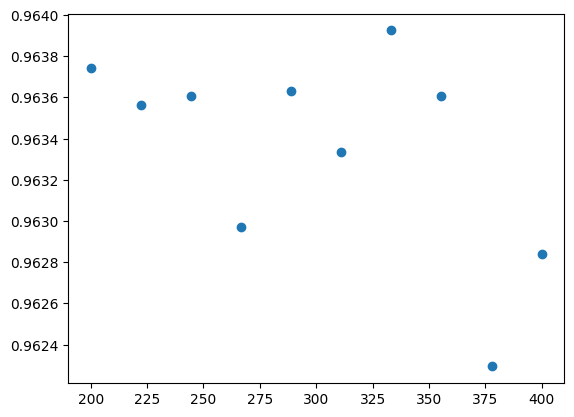

In [14]:
plt.scatter(sigma_rm, ratio)
# plt.ylim(0.92, 0.98)

## "Bias" is independent of the scale radius of tracer?

In [15]:
rs_kpc = np.linspace(2.5, 20, 10) / 0.763

ratio = []
sigma_e_sph = []
sigma_e_axi = []

if 1:

    for rs in rs_kpc:

        sigma_v = 200

        # define density profile
        lens_cosmo = get_default_lens_cosmo()
        distance = lens_cosmo.Dd
        theta_sis = lens_cosmo.sis_sigma_v2theta_E(sigma_v)
        rc_kpc = lens_cosmo.arcsec2Mpc_lens(theta_sis) * 1e3 * 200
        r_sym = np.geomspace(0.01, 5 * rc_kpc, 300)

        # intrinsic MGE for 3d spherical models and 3d axisymmetric models
        peak_sph3d, sigma_sph3d = get_truncsis_intr_mge(sigma_v, rc_kpc, r_sym, 1.0)
        peak_axi3d, sigma_axi3d = get_truncsis_intr_mge(sigma_v, rc_kpc, r_sym, qintr_test)

        # verify total mass
        # print(total_mass_3d(peak_sph3d, sigma_sph3d, 1) / 1e13)
        # print(total_mass_3d(peak_axi3d, sigma_axi3d, qintr_test) / 1e13)

        # calculate projected MGE
        mge_proj_axi = MGE_Proj(peak_axi3d, sigma_axi3d, qintr_test)
        mge_proj_sph = MGE_Proj(peak_sph3d, sigma_sph3d, 1.0)
        peak_axi3d_proj, sigma_axi3d_proj, qobs_axi_proj = get_proj_mge(mge_proj_axi, distance, inc_test) # project axisymmetric MGE
        peak_sph3d_proj, sigma_sph3d_proj, qobs_sph_proj = get_proj_mge(mge_proj_sph, distance, inc_test) # project intrinsically spherical MGE

        # circularize projected axisymmetric MGE 
        sigma_axi3d_proj_sph = sphericalize_2d(sigma_axi3d_proj, qobs_axi_proj)
        qobs_axi3d_proj_sph = np.ones_like(sigma_axi3d_proj_sph)

        # verify total mass
        pc = distance * np.pi / 0.648
        # print(total_mass_2d(peak_axi3d_proj, sigma_axi3d_proj, qobs_axi_proj) * pc**2 / 1e13)
        # print(total_mass_2d(peak_sph3d_proj, sigma_sph3d_proj, qobs_sph_proj) * pc**2 / 1e13)
        # print(total_mass_2d(peak_axi3d_proj, sigma_axi3d_proj_sph, qobs_axi3d_proj_sph) * pc**2 / 1e13)

        # get intrinsic MGE for light
        peak_sph3d_lum, sigma_sph3d_lum = get_jaffe_intr_mge(m_star, rs, 1.0)
        peak_axi3d_lum, sigma_axi3d_lum = get_jaffe_intr_mge(m_star, rs, qintr_test)

        # project intrinsic MGE for projected MGE
        mge_proj_sph_lum = MGE_Proj(peak_sph3d_lum, sigma_sph3d_lum, 1.0)
        mge_proj_axi_lum = MGE_Proj(peak_axi3d_lum, sigma_axi3d_lum, qintr_test)
        peak_axi3d_proj_lum, sigma_axi3d_proj_lum, qobs_axi_proj_lum = get_proj_mge(mge_proj_axi_lum, distance, inc_test) # project axisymmetric MGE
        peak_sph3d_proj_lum, sigma_sph3d_proj_lum, qobs_sph_proj_lum = get_proj_mge(mge_proj_sph_lum, distance, inc_test)# project intrinsically spherical MGE

        # circularize projected axisymmetric MGE 
        sigma_axi3d_proj_lum_sph = sphericalize_2d(sigma_axi3d_proj_lum, qobs_axi_proj_lum)
        qobs_axi3d_proj_lum_sph = np.ones_like(sigma_axi3d_proj_lum_sph)

        xx = np.linspace(-6 * theta_sis, 6 * theta_sis, 100)  # avoid (x,y)=(0,0)
        xbin, ybin = map(np.ravel, np.meshgrid(xx, xx))

        # run axisymmetric JAM modeling
        beta_axi3d = np.zeros_like(peak_axi3d_proj)

        jam_axi3d = jam_axi_proj(peak_axi3d_proj_lum, sigma_axi3d_proj_lum, qobs_axi_proj_lum, peak_axi3d_proj, sigma_axi3d_proj, qobs_axi_proj, np.degrees(inc_test), 0, distance, xbin, ybin, align='sph', beta = beta_axi3d)

        # plt.figure(2)
        sigma_e_axi3d = get_sigma_e(peak_axi3d_proj_lum, sigma_axi3d_proj_lum, qobs_axi_proj_lum, jam_axi3d, xbin, ybin, plot = False, fignum = 2)
        # ax = plt.gca()
        # ax.set_xlabel('arcsec', size = 20)
        # ax.set_ylabel('arcsec', size = 20)
        # ax.figure.axes[1].set_ylabel(r'$\sigma$ [km/s]', size = 20)

        # plt.show()

        # run circularized axisymmetric JAM modeling
        jam_axi3d_proj = jam_axi_proj(peak_axi3d_proj_lum, sigma_axi3d_proj_lum_sph, qobs_axi3d_proj_lum_sph, peak_axi3d_proj, sigma_axi3d_proj_sph, qobs_axi3d_proj_sph, np.degrees(inc_test), 0, distance, xbin, ybin, align = 'sph', beta = beta_axi3d)

        # plt.figure(3)
        sigma_e_axi3d_sph = get_sigma_e(peak_axi3d_proj_lum, sigma_axi3d_proj_lum_sph, qobs_axi3d_proj_lum_sph, jam_axi3d_proj, xbin, ybin, plot = False, fignum=3)

        # plt.show()

        # print(sigma_e_axi3d/sigma_e_axi3d_sph)
        ratio.append(sigma_e_axi3d/sigma_e_axi3d_sph)
        sigma_e_sph.append(sigma_e_axi3d_sph)
        sigma_e_axi.append(sigma_e_axi3d)

jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.76
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.124e+13

sigma_e = 155.72 km/s
jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.124e+13

sigma_e = 161.80 km/s
jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.77
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolution because sigmapsf=0 pixsize=0
inc=40.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 2.124e+13

sigma_e = 156.96 km/s
jam_axi_proj(align='sph', moment='zz') -- elapsed time sec: 0.71
analytic_los=0 logistic=0 constant_anisotropy=1
No PSF/pixel convolu

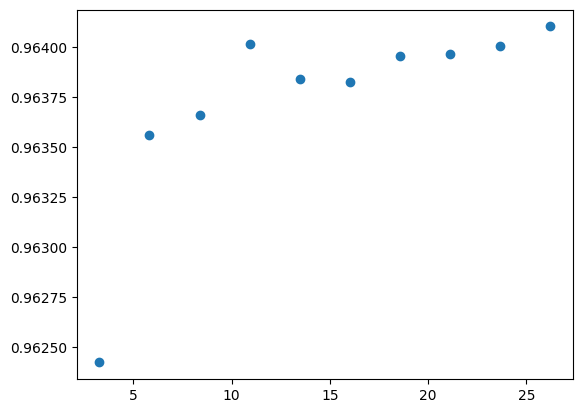

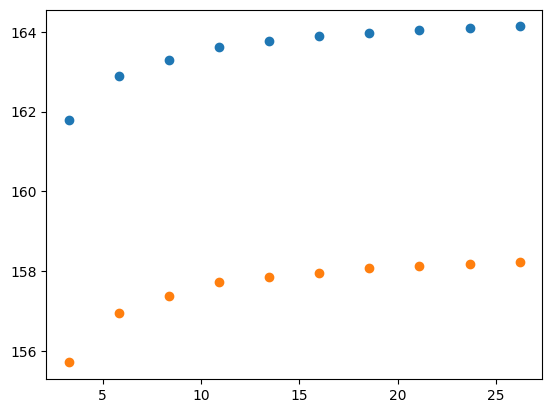

In [16]:
plt.scatter(rs_kpc, ratio)
# plt.ylim(0.9, 1.)

plt.figure()
plt.scatter(rs_kpc, sigma_e_sph)
plt.scatter(rs_kpc, sigma_e_axi)
